In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Inicia la sesión de Spark
spark = SparkSession.builder.appName("RunningDataClustering").getOrCreate()

# Carga los datos desde el CSV
data = spark.read.csv("running.csv", header=True, inferSchema=True, sep=";")

In [2]:
data.columns

['Date',
 'Hour',
 'Location',
 'Time full',
 'Time',
 'Distance_km',
 'Distance',
 'Pace']

In [3]:
# Selecciona las columnas relevantes (tiempo y distancia)
data = data.select("Time", "Distance")

# Elimina las filas con valores nulos
data = data.dropna()

data.head(3)

[Row(Time=2035, Distance=6800),
 Row(Time=1948, Distance=4560),
 Row(Time=1857, Distance=4590)]

In [4]:
# Convierte los datos a un formato adecuado para KMeans
assembler = VectorAssembler(inputCols=data.columns, outputCol="features")
final_data = assembler.transform(data)

In [21]:
    # Instancia el modelo KMeans con el número deseado de clusters
    kmeans = KMeans(featuresCol="features", k=4)

    # Entrena el modelo
    model = kmeans.fit(final_data)

In [22]:
# Obtiene las etiquetas de los clusters
predictions = model.transform(final_data)

# Visualiza los resultados
predictions.show()

+----+--------+----------------+----------+
|Time|Distance|        features|prediction|
+----+--------+----------------+----------+
|2035|    6800| [2035.0,6800.0]|         3|
|1948|    4560| [1948.0,4560.0]|         0|
|1857|    4590| [1857.0,4590.0]|         0|
|2145|    5260| [2145.0,5260.0]|         0|
|1526|    4250| [1526.0,4250.0]|         0|
|2611|    6680| [2611.0,6680.0]|         3|
|2974|    7010| [2974.0,7010.0]|         3|
|2479|    5450| [2479.0,5450.0]|         0|
|2568|    6720| [2568.0,6720.0]|         3|
|1451|    3440| [1451.0,3440.0]|         0|
|3062|    7370| [3062.0,7370.0]|         3|
|2602|    7370| [2602.0,7370.0]|         3|
|4643|   11150|[4643.0,11150.0]|         1|
|3107|    8550| [3107.0,8550.0]|         3|
|1499|    4750| [1499.0,4750.0]|         0|
|1980|    5050| [1980.0,5050.0]|         0|
|2076|    5510| [2076.0,5510.0]|         0|
|1500|    4830| [1500.0,4830.0]|         0|
|2316|    7250| [2316.0,7250.0]|         3|
|2239|    6600| [2239.0,6600.0]|

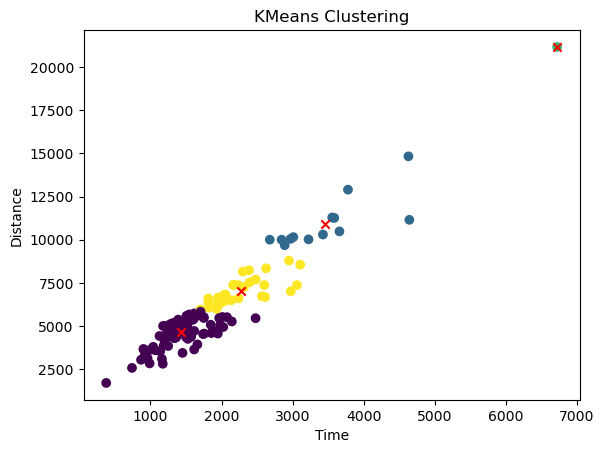

In [23]:
# Grafica los clusters
centers = model.clusterCenters()
plt.scatter(predictions.select('Time').collect(),
            predictions.select('Distance').collect(),
            c=predictions.select('prediction').collect(),
            cmap='viridis')
plt.scatter([c[0] for c in centers], [c[1] for c in centers], c='red', marker='x')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.title('KMeans Clustering')
plt.show()

In [24]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Calcula WSSSE (cuanto menor, mejor)
wssse = model.summary.trainingCost
print("Within Set Sum of Squared Errors = " + str(wssse))

# Calcula el coeficiente de Silhouette (1=buen cluster, -1=mal cluster)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Within Set Sum of Squared Errors = 125549755.55865663
Silhouette with squared euclidean distance = 0.7516482488666588


In [9]:
# Guarda los datos con las etiquetas de los clusters en un nuevo CSV
predictions.select('Time', 'Distance', 'prediction').toPandas().to_csv('running_clustered.csv', index=False)